In [826]:
from math import exp
import pandas as pd
import os
from pandas import DataFrame,Series
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy.random import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [57]:
# データが別のディレクトリにあるのでos.chdirを使って取得

os.chdir("/Users/interlude/Desktop/Kaggle/Titanic_ML")
train_org = pd.read_csv('train.csv')
test_org = pd.read_csv('test.csv')

In [58]:
train_org.info()
test_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float

Featureとして使うのは"Age"、"Sex"、Pclassです。<br>
"Age"にはNull値があるので補完する方法を考えます。

In [59]:
train_org.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [365]:
test_org.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


「'Pclass'が小さいほど(つまり良いクラスのお部屋に泊まってる人ほど)高齢である割合が高い」<br>
という仮説を検証してみます。<br>
この仮説が正しければ、'Age'データは'Pclass'によって偏りがあるという事になります。<br>
つまり、'Pclass'を基に補完する'Age'を決定すればより正確なデータになるのではないかと考えました。

In [337]:
train_Age_Pclass = DataFrame(train_org,columns=['Pclass','Age'])
test_Age_Pclass = DataFrame(test_org,columns=['Pclass','Age'])

In [366]:
train_Age_Pclass = train_Age_Pclass.dropna()
test_Age_Pclass = test_Age_Pclass.dropna()

In [367]:
train_Age_Pclass.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 3 columns):
Pclass    714 non-null int64
Age       714 non-null float64
key       714 non-null category
dtypes: category(1), float64(1), int64(1)
memory usage: 17.8 KB


In [368]:
test_Age_Pclass.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 332 entries, 0 to 415
Data columns (total 3 columns):
Pclass    332 non-null int64
Age       332 non-null float64
key       332 non-null category
dtypes: category(1), float64(1), int64(1)
memory usage: 8.5 KB


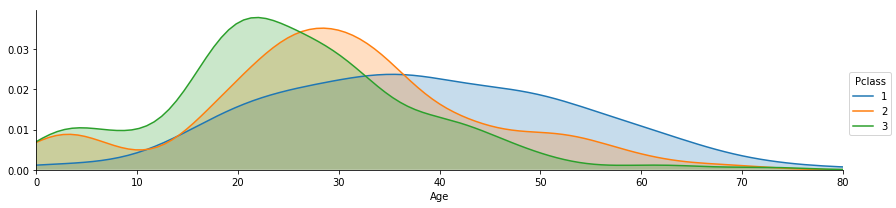

In [62]:
# 抽出したデータをグラフにします
fig = sns.FacetGrid(train_Age_Pclass, hue='Pclass',aspect=4)

fig.map(sns.kdeplot,'Age',shade=True)

oldest = train_Age_Pclass['Age'].max()

fig.set(xlim=(0,oldest))

fig.add_legend()

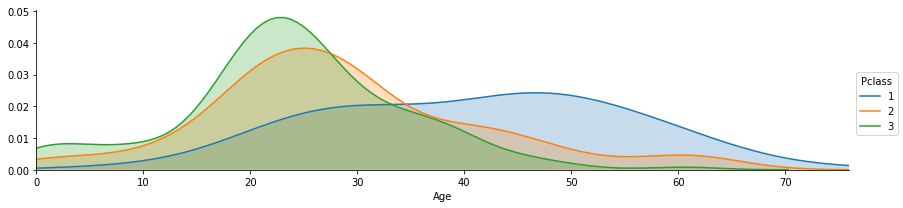

In [340]:
fig = sns.FacetGrid(test_Age_Pclass, hue='Pclass',aspect=4)

fig.map(sns.kdeplot,'Age',shade=True)

oldest = test_Age_Pclass['Age'].max()

fig.set(xlim=(0,oldest))

fig.add_legend()

グラフにして見た所仮説は正しそうなので、更に具体的な数値を出そうと思います。

In [341]:
label = ['u10', '10s', '20s', '30s', '40s', '50s', '60s', 'o70'] # 年齢層ごとのラベル。７０歳以上は細かく分けずに括りました。
train_Age_Pclass['key'] = pd.cut(train_Age_Pclass.Age, [0, 10, 20, 30, 40, 50, 60, 70, 80], labels=label)
test_Age_Pclass['key'] = pd.cut(test_Age_Pclass.Age,[0, 10, 20, 30, 40, 50, 60, 70, 80], labels=label)

In [351]:
train_Pc = train_Age_Pclass.groupby(['Pclass','key']).size()
test_Pc = test_Age_Pclass.groupby(['Pclass','key']).size()

In [352]:
train_Pc

Pclass  key
1       u10      3
        10s     18
        20s     40
        30s     49
        40s     37
        50s     25
        60s     11
        o70      3
2       u10     17
        10s     18
        20s     61
        30s     43
        40s     19
        50s     12
        60s      3
3       u10     44
        10s     79
        20s    129
        30s     63
        40s     30
        50s      5
        60s      3
        o70      2
dtype: int64

In [353]:
test_Pc

Pclass  key
1       u10     1
        10s     4
        20s    23
        30s    17
        40s    28
        50s    18
        60s     6
        o70     1
2       u10     5
        10s    15
        20s    40
        30s    12
        40s    11
        50s     2
        60s     3
3       u10    16
        10s    28
        20s    68
        30s    26
        40s     7
        60s     1
dtype: int64

In [459]:
train_Pclass1 = DataFrame(train_Pc[1], columns=['#people'])
train_Pclass2 = DataFrame(train_Pc[2], columns=['#people'])
train_Pclass3 = DataFrame(train_Pc[3], columns=['#people'])

test_Pclass1 = DataFrame(test_Pc[1], columns=['#people'])
test_Pclass2 = DataFrame(test_Pc[2], columns=['#people'])
test_Pclass3 = DataFrame(test_Pc[3], columns=['#people'])

train_Pclass2.loc['o70'] = 0 # Pclass2の'70s'の値がsizeメソッドで消えてしまったのでここで修正
test_Pclass2.loc['o70'] = 0
test_Pclass3.loc['50s'] = 0
test_Pclass3.loc['o70'] = 0

In [534]:
# Pclass毎の年齢層の割合を求めます
train_rate_AgeGroup_df = DataFrame(index = label, columns = ['Pclass1','Pclass2','Pclass3'])
for i in range(8):
    train_Num_arr = np.array([train_Pclass1.iat[i,0], train_Pclass2.iat[i,0], train_Pclass3.iat[i,0]])
    train_Den_arr = np.array([train_Pclass1.sum(axis=0)[0], train_Pclass2.sum(axis=0)[0], train_Pclass3.sum(axis=0)[0]])
    train_rate_arr = train_Num_arr / train_Den_arr
    train_rate_AgeGroup_df.iloc[i] = train_rate_arr
    
test_rate_AgeGroup_df = DataFrame(index = label, columns = ['Pclass1','Pclass2','Pclass3'])
for i in range(8):
    test_Num_arr = np.array([test_Pclass1.iat[i,0], test_Pclass2.iat[i,0], test_Pclass3.iat[i,0]])
    test_Den_arr = np.array([test_Pclass1.sum(axis=0)[0], test_Pclass2.sum(axis=0)[0], test_Pclass3.sum(axis=0)[0]])
    test_rate_arr = test_Num_arr / test_Den_arr
    test_rate_AgeGroup_df.iloc[i] = test_rate_arr

In [544]:
train_rate_AgeGroup_df

,Pclass1,Pclass2,Pclass3
u10,0.016129,0.0982659,0.123944
10s,0.0967742,0.104046,0.222535
20s,0.215054,0.352601,0.36338
30s,0.263441,0.248555,0.177465
40s,0.198925,0.109827,0.084507
50s,0.134409,0.0693642,0.0140845
60s,0.0591398,0.017341,0.0084507
o70,0.016129,0,0.0056338


In [541]:
test_rate_AgeGroup_df

,Pclass1,Pclass2,Pclass3
u10,0.0102041,0.0568182,0.109589
10s,0.0408163,0.170455,0.191781
20s,0.234694,0.454545,0.465753
30s,0.173469,0.136364,0.178082
40s,0.285714,0.125,0.0479452
50s,0.183673,0.0227273,0.00684932
60s,0.0612245,0.0340909,0
o70,0.0102041,0,0


上のDataFrameからPclass1は４０歳以上が他のPclassと比べてかなり多いことがわかりました。<br>
このデータを基にnull値を補完していきます。<br>
その前にデータセットの'Age'のnull値がある列だけ抽出します。

In [670]:
train_null_Age = DataFrame(train_org, columns = ['Age','Pclass'])
test_null_Age = DataFrame(test_org,columns = ['Age', 'Pclass'])

In [671]:
train_null_Age = train_null_Age[train_null_Age['Age'].isnull()]
test_null_Age = test_null_Age[test_null_Age['Age'].isnull()]

In [672]:
train_null_Age.head(3)

,Age,Pclass
5,NaN,3
17,NaN,2
19,NaN,3


In [673]:
test_null_Age.head(3)

,Age,Pclass
10,NaN,3
22,NaN,1
29,NaN,3


In [590]:
train_rate_AgeGroup_df

,Pclass1,Pclass2,Pclass3
u10,0.016129,0.0982659,0.123944
10s,0.0967742,0.104046,0.222535
20s,0.215054,0.352601,0.36338
30s,0.263441,0.248555,0.177465
40s,0.198925,0.109827,0.084507
50s,0.134409,0.0693642,0.0140845
60s,0.0591398,0.017341,0.0084507
o70,0.016129,0,0.0056338


In [712]:
p_1 = train_rate_AgeGroup_df.iloc[:,0]
p_2 = train_rate_AgeGroup_df.iloc[:,1]
p_3 = train_rate_AgeGroup_df.iloc[:,2]

p_4 = test_rate_AgeGroup_df.iloc[:,0]
p_5 = test_rate_AgeGroup_df.iloc[:,1]
p_6 = test_rate_AgeGroup_df.iloc[:,2]

In [711]:
train_Age_Pclass.groupby(['Pclass','key']).mean()

Age
Pclass key           
1      u10   2.306667
       10s  17.000000
       20s  25.600000
       30s  35.877551
       40s  46.391892
       50s  55.160000
       60s  63.545455
       o70  74.000000
2      u10   3.490000
       10s  17.500000
       20s  25.967213
       30s  34.709302
       40s  45.315789
       50s  54.916667
       60s  66.000000
       o70        NaN
3      u10   4.702727
       10s  17.348101
       20s  25.112403
       30s  34.642857
       40s  44.150000
       50s  53.500000
       60s  63.000000
       o70  72.250000

In [805]:
# 各年齢層の平均をPclass毎に求めてリストに格納しておきます
Age_mean1 = [2, 17, 26, 36, 46, 55, 63, 74]
Age_mean2 = [4, 18, 26, 35, 45, 54, 66, 0]
Age_mean3 = [5, 17, 25, 35, 44, 54, 63, 72]
fill_Age = [] # このリストに割り振られた年齢を格納していきます
for i in range(len(train_null_Age.index)):
    if train_null_Age.iat[i,1] == 1:
        fill_Age.extend(choice(Age_mean1, 1, p = [p_1['u10'], p_1['10s'], p_1['20s'], p_1['30s'], p_1['40s'], p_1['50s'], p_1['60s'], p_1['o70']]))
    elif train_null_Age.iat[i,1] == 2:
        fill_Age.extend(choice(Age_mean2, 1, p = [p_2['u10'], p_2['10s'], p_2['20s'], p_2['30s'], p_2['40s'], p_2['50s'], p_2['60s'], p_2['o70']]))
    else:
        fill_Age.extend(choice(Age_mean3, 1, p = [p_3['u10'], p_3['10s'], p_3['20s'], p_3['30s'], p_3['40s'], p_3['50s'], p_3['60s'], p_3['o70']]))

In [806]:
test_Age_Pclass.groupby(['Pclass','key']).mean()

Age
Pclass key           
1      u10   6.000000
       10s  16.500000
       20s  25.891304
       30s  35.382353
       40s  45.821429
       50s  55.500000
       60s  63.833333
       o70  76.000000
2      u10   3.984000
       10s  17.366667
       20s  25.800000
       30s  35.416667
       40s  44.727273
       50s  58.500000
       60s  62.000000
       o70        NaN
3      u10   4.442500
       10s  17.214286
       20s  24.514706
       30s  35.230769
       40s  44.500000
       50s        NaN
       60s  60.500000
       o70        NaN

In [807]:
Age_mean4 = [6, 17, 26, 35, 46, 56, 64, 76]
Age_mean5 = [4, 17, 26, 35, 45, 59, 62, 0]
Age_mean6 = [4, 17, 25, 35, 45, 0, 61, 0]
test_fill_Age = [] # このリストに割り振られた年齢を格納していきます
for i in range(len(test_null_Age.index)):
    if test_null_Age.iat[i,1] == 1:
        test_fill_Age.extend(choice(Age_mean4, 1, p = [p_4['u10'], p_4['10s'], p_4['20s'], p_4['30s'], p_4['40s'], p_4['50s'], p_4['60s'], p_4['o70']]))
    elif test_null_Age.iat[i,1] == 2:
        test_fill_Age.extend(choice(Age_mean5, 1, p = [p_5['u10'], p_5['10s'], p_5['20s'], p_5['30s'], p_5['40s'], p_5['50s'], p_5['60s'], p_5['o70']]))
    else:
        test_fill_Age.extend(choice(Age_mean6, 1, p = [p_6['u10'], p_6['10s'], p_6['20s'], p_6['30s'], p_6['40s'], p_6['50s'], p_6['60s'], p_6['o70']]))

In [808]:
train_fill_Age = dict(fill_Age_srr)
test_fill_Age = dict(test_fill_Age_srr)

In [809]:
train_df = DataFrame(train_org, columns=['Age','Pclass','Sex','Survived'])

test_df = DataFrame(test_org, columns=['Age','Pclass','Sex'])

In [810]:
train_df['Age'] = train_df['Age'].fillna(train_fill_Age)

test_df['Age'] = test_df['Age'].fillna(test_fill_Age)

In [811]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 4 columns):
Age         891 non-null float64
Pclass      891 non-null int64
Sex         891 non-null object
Survived    891 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 27.9+ KB


In [812]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 3 columns):
Age       418 non-null float64
Pclass    418 non-null int64
Sex       418 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 9.9+ KB


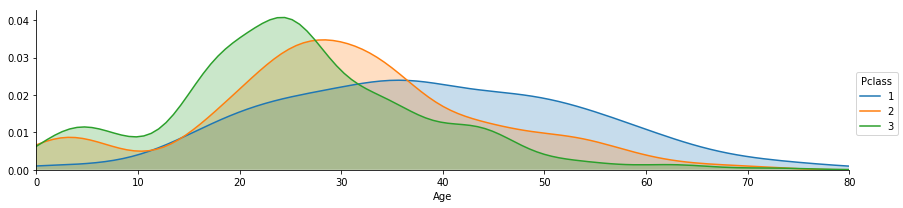

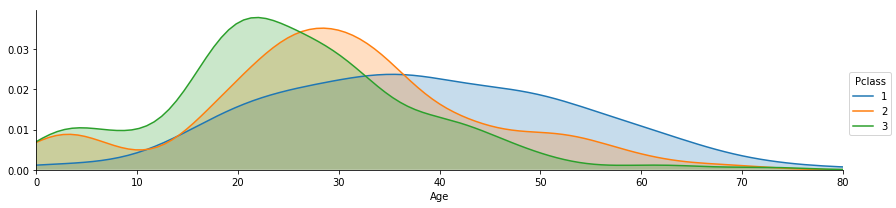

In [813]:
fig = sns.FacetGrid(train_df, hue='Pclass',aspect=4)

fig.map(sns.kdeplot,'Age',shade=True)

oldest = train_df['Age'].max()

fig.set(xlim=(0,oldest))

fig.add_legend()

fig = sns.FacetGrid(train_Age_Pclass, hue='Pclass',aspect=4)

fig.map(sns.kdeplot,'Age',shade=True)

oldest = train_Age_Pclass['Age'].max()

fig.set(xlim=(0,oldest))

fig.add_legend()

ちょっと山の形が変わりましたね…

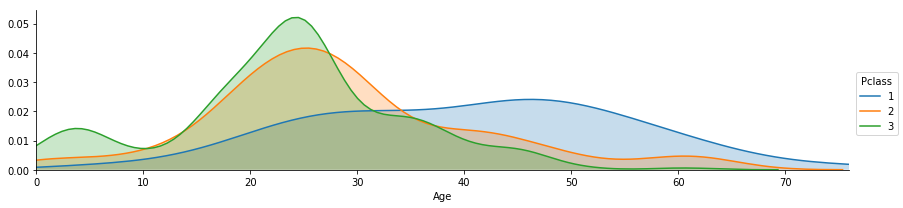

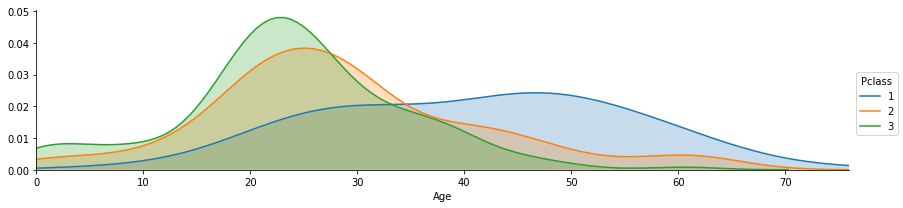

In [814]:
fig = sns.FacetGrid(test_df, hue='Pclass',aspect=4)

fig.map(sns.kdeplot,'Age',shade=True)

oldest = test_df['Age'].max()

fig.set(xlim=(0,oldest))

fig.add_legend()

fig = sns.FacetGrid(test_Age_Pclass, hue='Pclass',aspect=4)

fig.map(sns.kdeplot,'Age',shade=True)

oldest = test_Age_Pclass['Age'].max()

fig.set(xlim=(0,oldest))

fig.add_legend()

結構良い感じな気がします！！<br>
他のデータの前処理もささっと終わらせます。<br>
'Sex'と'Pclass'はダミー変数に置き換えます。<br>
この辺の細かい説明は省略します！

In [815]:
train_df['Female'] = train_df['Sex'].map({'female':1, 'male':0}).astype(int)

test_df['Female'] = test_df['Sex'].map({'female':1, 'male':0}).astype(int)

In [816]:
train_df.head()

,Age,Pclass,Sex,Survived,Female
0,22.0,3,male,0,0
1,38.0,1,female,1,1
2,26.0,3,female,1,1
3,35.0,1,female,1,1
4,35.0,3,male,0,0


In [817]:
test_df.head()

,Age,Pclass,Sex,Female
0,34.5,3,male,0
1,47.0,3,female,1
2,62.0,2,male,0
3,27.0,3,male,0
4,22.0,3,female,1


In [818]:
Pclass_train_df = pd.get_dummies(train_df['Pclass'], prefix='Class')
Pclass_test_df = pd.get_dummies(test_df['Pclass'], prefix='Class')

In [819]:
Pclass_train_df.head()

,Class_1,Class_2,Class_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


In [820]:
Pclass_train_df = Pclass_train_df.drop(['Class_3'], axis=1)
Pclass_test_df = Pclass_test_df.drop(['Class_3'], axis=1)

In [822]:
train_df = train_df.join(Pclass_train_df)
test_df = test_df.join(Pclass_test_df)

In [823]:
train_df.head()

,Age,Pclass,Sex,Survived,Female,Class_1,Class_2
0,22.0,3,male,0,0,0,0
1,38.0,1,female,1,1,1,0
2,26.0,3,female,1,1,0,0
3,35.0,1,female,1,1,1,0
4,35.0,3,male,0,0,0,0


In [824]:
X = train_df.drop(['Pclass','Sex','Survived'], axis=1)
y = train_df.Survived

In [827]:
clf = LogisticRegression()

clf.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [828]:
predict_y = clf.predict(X)
accuracy_score(y, predict_y)

0.8002244668911336

In [829]:
test_model_df = test_df.drop(['Pclass','Sex'],axis=1)

In [830]:
test_predict = clf.predict(test_model_df)
print(test_predict)

[0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 1 1 0 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0
 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 1 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 1 0 0 1 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 1 0 1 1 0
 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0
 0 0 1 1 1 1 0 1 0 0 0]


In [832]:
test_df = pd.read_csv('test.csv')
PassengerId =np.array(test_df["PassengerId"]).astype(int)
my_solution = pd.DataFrame(test_predict, PassengerId, columns = ["Survived"])
my_solution.to_csv("my_solution_ver2.csv", index_label = ["PassengerId"])

スコアは前回提出したモデルに比べて1％ほど精度が上がりました。<br>
単に欠損値補完を工夫しただけなのでこんなものかなって感じです。<br>
80%台に上げるには特徴量そのものを工夫するか機械学習モデルの工夫が必要なんでしょう。<br>
何れにせよ、「PclassとAgeの相関関係から高精度の欠損値補完を行う」作業は成功(？)だと思います。